# Metadata

```
Course:   DS 5001 
Module:   09 Lab
Topic:    Word2Vec
Author:   R.C. Alvarado
 
Purpose:  We create our own word embeddings with novel data using word2vec and visualize results with tSNE.
```

# Set Up

In [2]:
data_home = '../data'
data_prefix = 'novels'
data_prefix2 ="output/austen-melville"

In [3]:
OHCO = ['book_id','chap_id','para_num','sent_num','token_num']

In [4]:
w2v_params = dict(
    min_count = 10,
    workers = 4,
    # vector_size = 246,
    vector_size = 100,
    window = 2    
)

In [5]:
tsne_params = dict(
    learning_rate = 200., #'auto' or [10.0, 1000.0]
    perplexity = 40,
    n_components = 2,
    init = 'random',
    n_iter = 1000,
    random_state = 23    
)

In [6]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly_express as px

# Get Data

In [7]:
TOKENS = pd.read_csv(f"{data_home}/{data_prefix2}-CORPUS2.csv").set_index(OHCO)

In [8]:
TOKENS.head()

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                             
105     1       1        0        0               ('Sir', 'NNP')  NNP   
                                  1            ('Walter', 'NNP')  NNP   
                                  2           ('Elliot,', 'NNP')  NNP   
                                  3                 ('of', 'IN')   IN   
                                  4          ('Kellynch', 'NNP')  NNP   

                                            token_str  term_str pos_group  
book_id chap_id para_num sent_num token_num                                
105     1       1        0        0               Sir       sir        NN  
                                  1            Walter    walter        NN  
                                  2           Elliot,    elliot        NN  
                                  3                of        of        IN  
                                  4          Kellynch  kellynch        NN

In [9]:
## Step 1: Load LIB and split corpus

## Extract library

LIB=pd.read_csv(f"{data_home}/output/austen-melville-LIB2.csv")
LIB.head()

book_id                                   source_file_path        author  \
0      105  ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
1      121  ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
2      141  ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
3      158  ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   
4      161  ../data/gutenberg/austen-melville-set/AUSTEN_J...  AUSTEN, JANE   

                  title                   chap_regex  book_len  n_chaps  \
0            PERSUASION              ^Chapter\s+\d+$     83624       24   
1      NORTHANGER ABBEY              ^CHAPTER\s+\d+$     77601       31   
2        MANSFIELD PARK        ^CHAPTER\s+[IVXLCM]+$    160378       48   
3                  EMMA  ^\s*CHAPTER\s+[IVXLCM]+\s*$    160926       55   
4  SENSE AND SENSIBILIT              ^CHAPTER\s+\d+$    119873       50   

      genre     mood                    label  
0  domestic  romance  AUSTEN–PERSUASION–D–105  
1    gothic   satire  AUSTEN–NORTHANGER–G–121  
2  domestic   satire  AUSTEN–MANSFIELD –D–141  
3  domestic  romance        AUSTEN–EMMA–D–158  
4  domestic  romance  AUSTEN–SENSE AND –D–161

In [28]:
austen_ids=list(LIB[LIB.author=="AUSTEN, JANE"].book_id)
melville_ids=list(LIB[LIB.author!="AUSTEN, JANE"].book_id)
type(austen_ids)
len(melville_ids)
len(austen_ids)

8

In [21]:
TOKENS2=TOKENS.reset_index()
TOKENS_A=TOKENS2[TOKENS2.book_id.isin(austen_ids)]
TOKENS_M=TOKENS2[TOKENS2.book_id.isin(melville_ids)]

In [27]:
TOKENS_M.book_id.value_counts().shape
TOKENS_A.book_id.value_counts().shape

(8,)

# Extract VOCAB

Use this to filter significant terms and to store w2v features and tSNE coordinates.

In [31]:
VOCAB_A = TOKENS_A.term_str.value_counts().to_frame('n')
VOCAB_A.index.name = 'term_str'

In [33]:
VOCAB_M = TOKENS_M.term_str.value_counts().to_frame('n')
VOCAB_M.index.name = 'term_str'

In [34]:
VOCAB_A['pos_max'] = TOKENS_A.value_counts(['term_str','pos']).unstack().idxmax(1)
VOCAB_M['pos_max'] = TOKENS_M.value_counts(['term_str','pos']).unstack().idxmax(1)

In [38]:
VOCAB_M

n pos_max
term_str                    
the            76600      DT
of             40226      IN
and            37044      CC
to             28368      TO
a              28255      DT
...              ...     ...
kilkenny           1     NNP
doxdox             1     NNP
curfew             1      NN
whack              1      NN
psychologists      1     NNS

[36836 rows x 2 columns]

In [40]:
VOCAB_A['pos_group'] = VOCAB_A.pos_max.str.slice(0,2)
VOCAB_M['pos_group'] = VOCAB_M.pos_max.str.slice(0,2)

In [42]:
VOCAB_A

n pos_max pos_group
term_str                         
the       28274      DT        DT
to        26029      TO        TO
and       24060      CC        CC
of        22927      IN        IN
a         14301      DT        DT
...         ...     ...       ...
2nd           1      CD        CD
admits        1     VBZ        VB
cleanse       1      VB        VB
senior        1      NN        NN
cocoa         1      NN        NN

[14745 rows x 3 columns]

# Add Chapter Significance

In [11]:
CHAPS = TOKENS.groupby(OHCO[:2]+['term_str']).term_str.count()\
    .unstack(fill_value=0).astype('bool').astype('int')

In [12]:
CHAPS.head()

term_str            a  aback  abaft  abandon  abandoned  abandoning  abandons  \
book_id    chap_id                                                              
adventures 1        1      0      0        0          1           0         0   
           2        1      0      0        0          0           0         0   
           3        1      0      0        0          0           0         0   
           4        1      0      0        0          0           0         0   
           5        1      0      0        0          0           0         0   

term_str            abasement  abashed  abate  ...  zoöphagy  zufalle  zum  \
book_id    chap_id                             ...                           
adventures 1                0        0      0  ...         0        0    0   
           2                0        0      0  ...         0        0    0   
           3                0        0      0  ...         0        0    0   
           4                0        0      0  ...         0        0    0   
           5                0        0      0  ...         0        0    0   

term_str            zuniga  zusammen  à  æt  ætat  ça  émeutes  
book_id    chap_id                                              
adventures 1             0         0  0   0     0   0        0  
           2             0         0  0   0     0   0        0  
           3             0         0  0   0     0   0        0  
           4             0         0  0   0     0   0        0  
           5             0         0  0   0     0   0        0  

[5 rows x 27396 columns]

In [13]:
VOCAB['df'] = CHAPS.sum()
VOCAB['dfidf'] = VOCAB.df * np.log2(len(CHAPS)/VOCAB.df)

In [14]:
VOCAB.sort_values('dfidf', ascending=False)

n pos_max pos_group   df       dfidf
term_str                                           
written      214     VBN        VB  118  169.835635
reply        184      NN        NN  118  169.835635
curiosity    208      NN        NN  118  169.835635
order        227      NN        NN  118  169.835635
yours        198      NN        NN  118  169.835635
...          ...     ...       ...  ...         ...
by          6923      IN        IN  320    0.000000
from        6780      IN        IN  320    0.000000
no          5200      DT        DT  320    0.000000
to         45176      TO        TO  320    0.000000
the        85329      DT        DT  320    0.000000

[27396 rows x 5 columns]

# Get List of Token Lists

Because that's what Gensim wants.

In [15]:
SENTS = TOKENS.groupby(OHCO[:-1]).term_str.apply(lambda  x:  x.tolist())

# Learn Word Embeddings

In [16]:
SENTS.head().tolist()

[['a', 'scandal', 'in', 'bohemia'],
 ['i'],
 ['to', 'sherlock', 'holmes', 'she', 'is', 'always', 'the', 'woman'],
 ['i',
  'have',
  'seldom',
  'heard',
  'him',
  'mention',
  'her',
  'under',
  'any',
  'other',
  'name'],
 ['in',
  'his',
  'eyes',
  'she',
  'eclipses',
  'and',
  'predominates',
  'the',
  'whole',
  'of',
  'her',
  'sex']]

In [17]:
model = word2vec.Word2Vec(SENTS.values, **w2v_params)

In [18]:
W2V = pd.DataFrame(model.wv.get_normed_vectors(), index=model.wv.index_to_key)
W2V.index.name = 'term_str'
W2V = W2V.sort_index()

In [19]:
W2V.head()

0         1         2         3         4         5   \
term_str                                                                
a         -0.156822 -0.141512  0.058362 -0.121479 -0.109306 -0.043568   
abandon    0.077669  0.107142 -0.132387 -0.023468  0.044456 -0.141033   
abandoned -0.062436  0.083255 -0.073115  0.105677  0.019760 -0.052753   
abated    -0.040383  0.128787 -0.149692 -0.027003 -0.005621 -0.049957   
abbess    -0.096884 -0.059930 -0.163366 -0.032588  0.039693 -0.052835   

                 6         7         8         9   ...        90        91  \
term_str                                           ...                       
a          0.068902  0.031610 -0.054520 -0.070424  ...  0.129569  0.077552   
abandon    0.007072  0.307405 -0.068245 -0.113058  ...  0.034382 -0.126472   
abandoned  0.021934  0.229312 -0.084526 -0.068473  ...  0.106733  0.045094   
abated     0.015184  0.317607 -0.066498 -0.065013  ...  0.093927  0.063384   
abbess     0.000636  0.090850 -0.030478 -0.117478  ...  0.200965  0.083627   

                 92        93        94        95        96        97  \
term_str                                                                
a         -0.009689  0.009901  0.115975  0.178070  0.007851 -0.077352   
abandon    0.047276  0.080338  0.082529 -0.044679  0.040548 -0.076689   
abandoned  0.015244  0.146692  0.081515  0.063845 -0.003426 -0.062510   
abated     0.015046  0.071741  0.227674  0.031953  0.012337 -0.010529   
abbess    -0.007683  0.131199  0.215634 -0.005136  0.139911  0.039695   

                 98        99  
term_str                       
a          0.065525 -0.097802  
abandon   -0.051716  0.056850  
abandoned  0.091447 -0.075987  
abated    -0.005418  0.087314  
abbess     0.112934  0.094199  

[5 rows x 100 columns]

# Visualize with tSNE

In [20]:
tsne_engine = TSNE(**tsne_params)
tsne_model = tsne_engine.fit_transform(W2V)

In [21]:
COORDS = pd.DataFrame(tsne_model, columns=['x','y'], index=W2V.index)\
    .join(VOCAB, how='left')[['x','y','n','dfidf','pos_group']]

In [22]:
COORDS

x          y      n       dfidf pos_group
term_str                                                    
a         -24.551088  26.401798  28533    0.000000        DT
abandon   -47.274448  24.517481     44   98.408049        VB
abandoned   3.470828  49.869755     68  124.513524        VB
abated     16.661758  25.118069     12   50.000000        VB
abbess     51.287178   4.259567     69   56.843587        NN
...              ...        ...    ...         ...       ...
youthful  -10.641273  -9.528577     18   74.736056        JJ
youths      3.017108 -16.009602     19   50.000000        NN
youve      28.568058  27.933096     61  116.812022        NN
zadisky    39.529408  18.154449     27   34.421794        NN
zeal      -34.628658 -22.689344     26   87.362421        NN

[7857 rows x 5 columns]

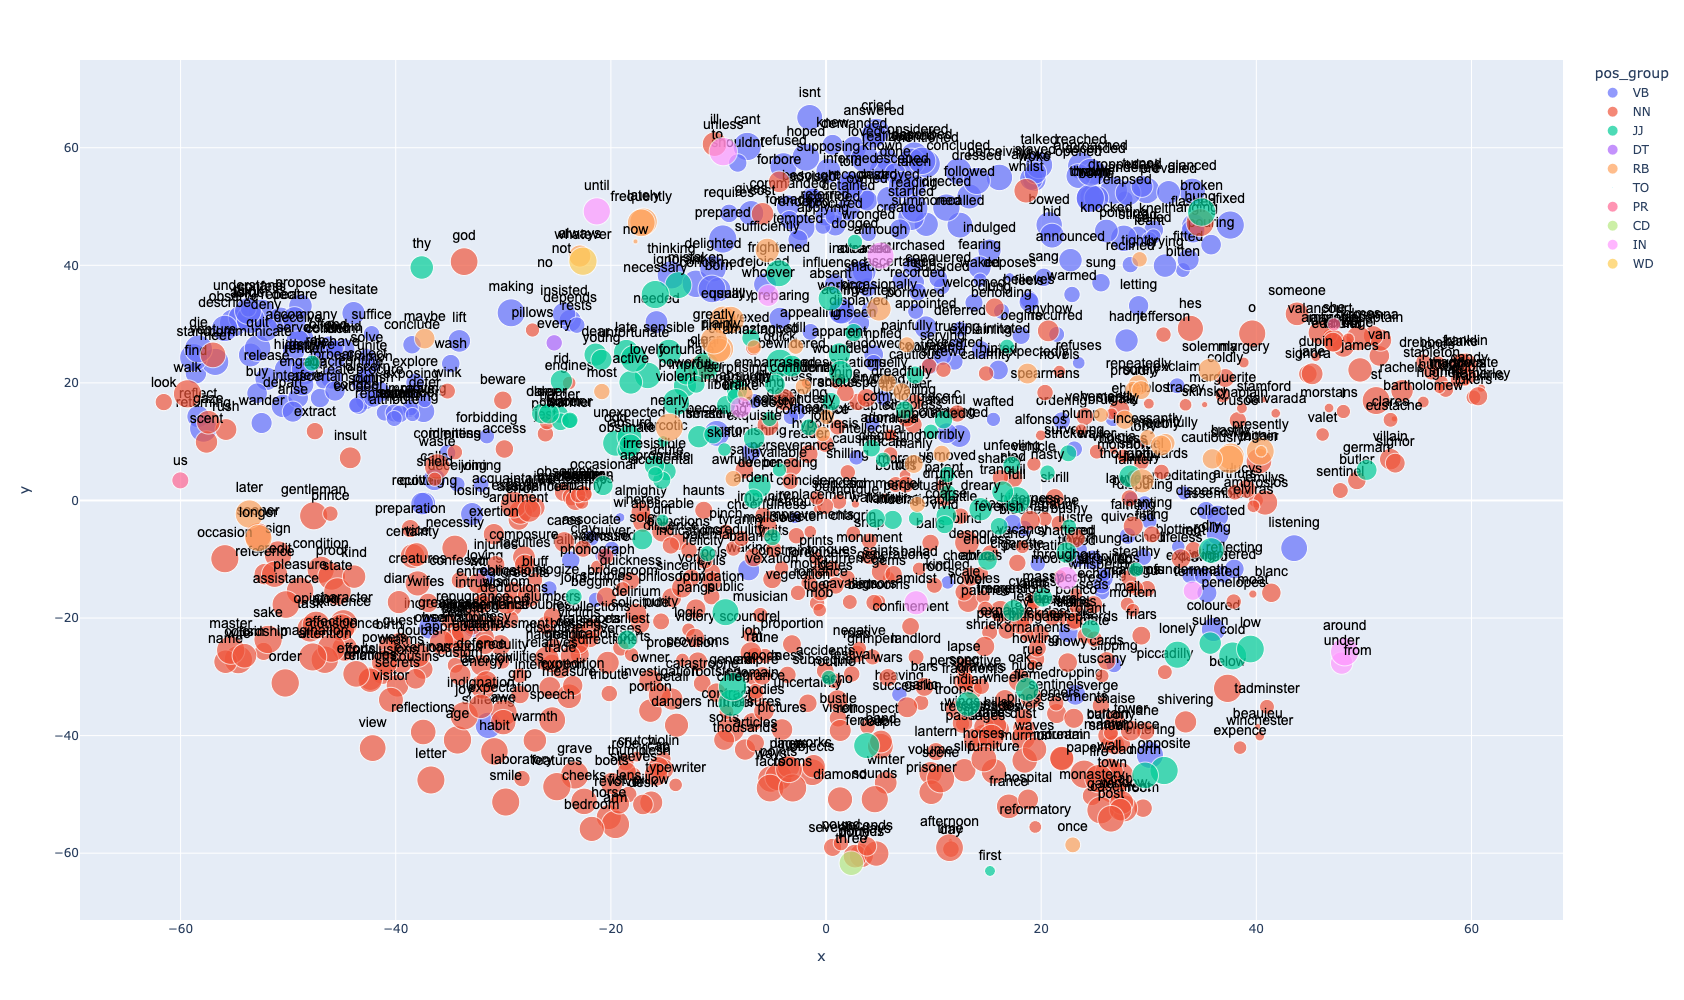

In [23]:
px.scatter(COORDS.reset_index().sample(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

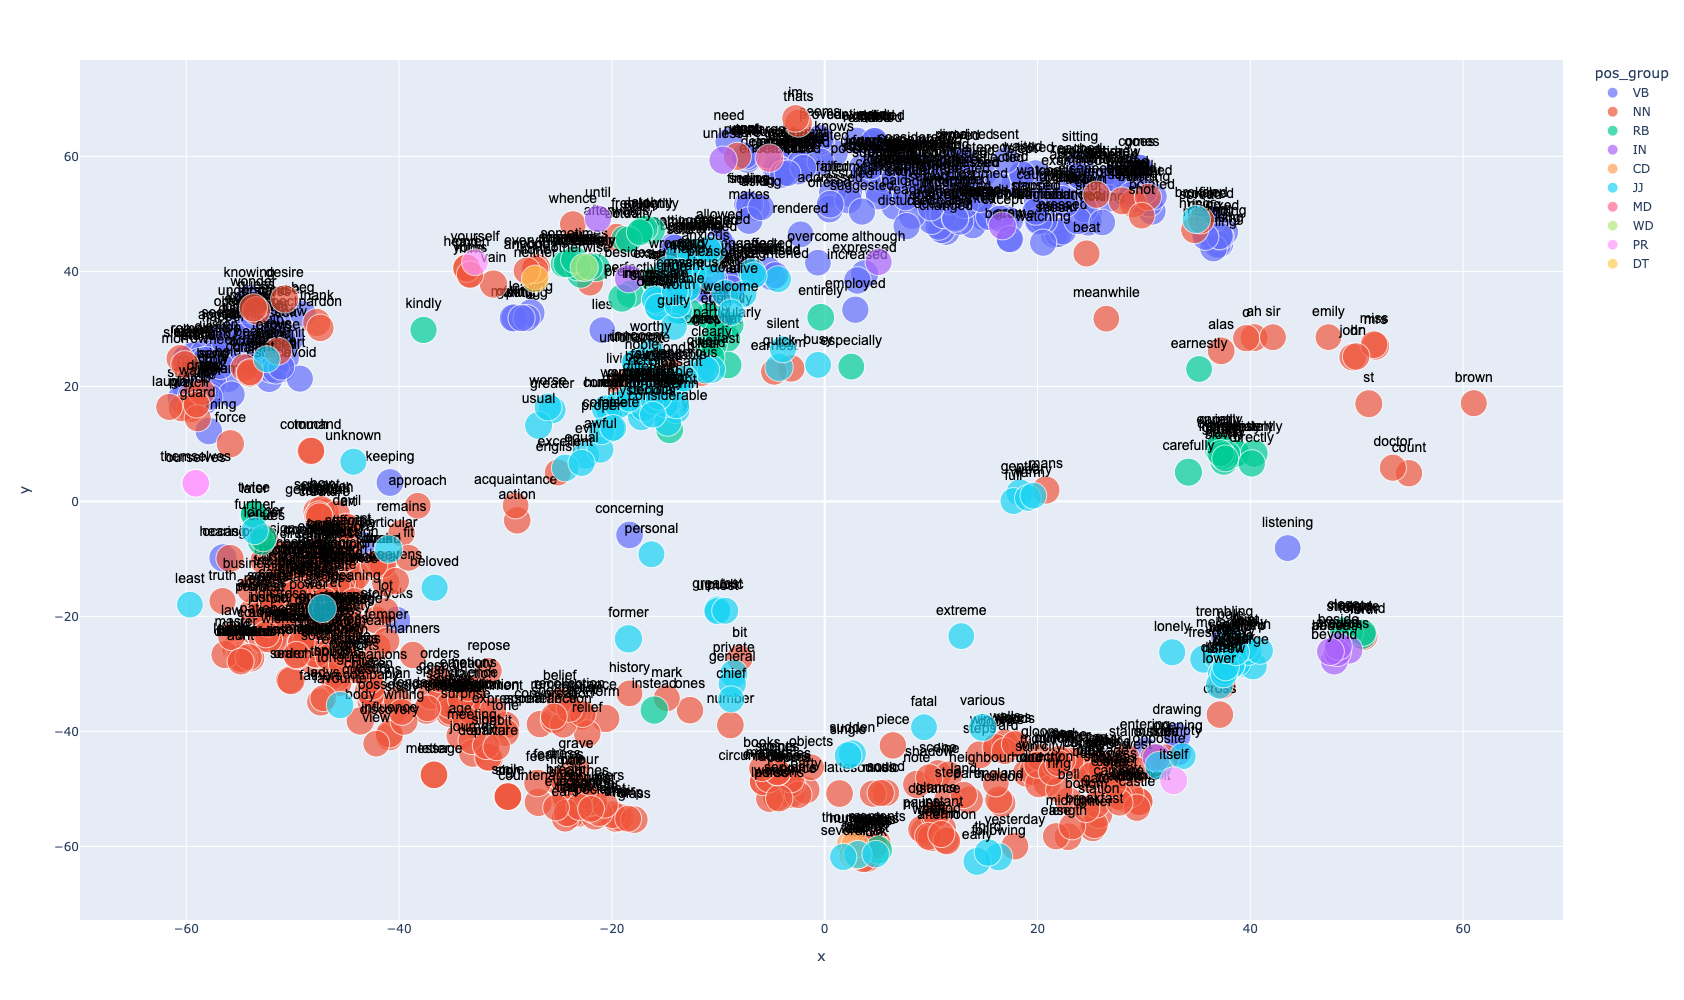

In [24]:
px.scatter(COORDS.reset_index().sort_values('dfidf', ascending=False).head(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Semantic Algebra

## Analogies

$A : B :: C : D? \rightarrow B - A + C = D$


In [25]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [26]:
complete_analogy('man', 'boy', 'woman', 3)

term       sim
0     girl  0.821539
1      lad  0.815851
2  peasant  0.793733

In [27]:
complete_analogy('girl', 'daughter', 'boy', 3)

term       sim
0  companion  0.815791
1       wife  0.812413
2    husband  0.809457

In [28]:
complete_analogy('girl', 'sister', 'boy', 3)

term       sim
0   cousin  0.847528
1  brother  0.835758
2     wife  0.829594

In [29]:
complete_analogy('man', 'gentleman', 'woman', 5)

term       sim
0      girl  0.853864
1    fellow  0.824815
2   peasant  0.823388
3  creature  0.788830
4   servant  0.781692

In [30]:
complete_analogy('woman', 'lady', 'man', 5)

term       sim
0    servant  0.763549
1       girl  0.735958
2  gentleman  0.713840
3        boy  0.694750
4     fellow  0.667220

In [31]:
complete_analogy('day', 'sun', 'night', 5)

term       sim
0    rain  0.774231
1  clouds  0.770300
2    wind  0.750814
3  slowly  0.745924
4   gates  0.745153

## Similarites

In [32]:
get_most_similar('joy')

term       sim
0      admiration  0.893006
1          horror  0.890130
2         delight  0.875083
3         anxiety  0.861079
4     indignation  0.841090
5          terror  0.840981
6         concern  0.838781
7           grief  0.837115
8  disappointment  0.836615
9         anguish  0.834368

In [33]:
get_most_similar('man')

term       sim
0      woman  0.888368
1  gentleman  0.865108
2       girl  0.800952
3   creature  0.792831
4     person  0.739616
5   stranger  0.734240
6     fellow  0.712108
7    servant  0.699774
8    peasant  0.685701
9     wretch  0.670483

In [34]:
get_most_similar(positive=['man'], negative=['woman'])

term       sim
0  together  0.378737
1      down  0.376979
2        us  0.376940
3      into  0.362327
4        up  0.349172
5     along  0.347316
6      back  0.332531
7       off  0.324062
8      them  0.322100
9      road  0.317505

In [35]:
get_most_similar(positive='woman')

term       sim
0  gentleman  0.902793
1       girl  0.895676
2        man  0.888368
3   creature  0.857823
4     fellow  0.812371
5    peasant  0.784159
6     wretch  0.777656
7   stranger  0.764081
8    servant  0.757685
9     prince  0.734610

In [36]:
get_most_similar(positive=['woman'], negative=['man'])

term       sim
0     late  0.486138
1  dearest  0.469553
2        o  0.460697
3    young  0.459534
4     poor  0.456867
5     dear  0.450438
6     emma  0.434393
7   mother  0.415621
8   lovely  0.414429
9  beloved  0.412167

In [37]:
get_most_similar(['man','woman'],['boy','girl'])

term       sim
0     such  0.379234
1       an  0.357219
2   strong  0.352436
3      any  0.345511
4    human  0.337365
5     most  0.321824
6   single  0.302327
7   seemed  0.302142
8    whose  0.297021
9  similar  0.283543

# Save

In [38]:
W2V.to_csv(f'{data_home}/{data_prefix}/{data_prefix}-W2V.csv')
VOCAB.to_csv(f'{data_home}/{data_prefix}/{data_prefix}-VOCAB.csv')
SENTS.to_csv(f'{data_home}/{data_prefix}/{data_prefix}-GENSIM_DOCS.csv')

# Experiment: W2V Features as Topics

In [39]:
W2V.describe().T.style.background_gradient(cmap='GnBu')

In [40]:
VSIGS = VOCAB.sort_values('dfidf').tail(1000)

In [41]:
W2Vp = (W2V - W2V.min()) #[0].sort_values().plot()
W2Vp = W2Vp.loc[VSIGS.index]
W2Vp = W2Vp / W2Vp.sum()

In [42]:
# W2Vp[0].sort_values(ascending=False).head(100).plot()

In [43]:
topics = []
for i in W2Vp.columns:
    top_words = ' '.join(W2V.sort_values(i, ascending=False).index[:10])
    print(i, top_words)
    topics.append((i, top_words))

0 sooner either better farther earth hear side further subject wrong
1 over above open through oer amidst gloomy fierce iron became
2 is seems isnt good doesnt comes every wasnt does cannot
3 opened threw at found retired reached closed carried chamber shut
4 sister son cousin julia friend excellenza lordship brother brothers thank
5 already during been among by after since from through remembrance
6 effort than single glimpse little glance or composed sudden hint
7 promising suitor warmly offering dishonour affording term unendurable foolish favourable
8 nor all what neither your none now nothing she thy
9 be appeared scarcely being been she however was mentioned even
10 sweet strangely thats fond beautiful clear simple pretty sad bad
11 nor yet scarcely find else whom heard hardly neither seen
12 understand explain perceive surely swear imagine thank oh madam assure
13 go walked come examine ascend walk dance leave went quit
14 view connected connection conversation age world resembl

In [44]:
# topics

<AxesSubplot:xlabel='term_str'>

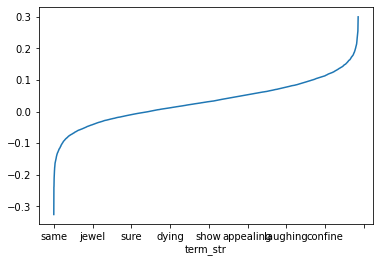

In [45]:
W2V[4].sort_values().plot()

<AxesSubplot:>

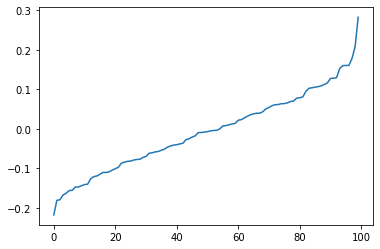

In [46]:
W2V.iloc[0].sort_values().reset_index(drop=True).plot()